In [1]:
!pip install --quiet scikit-image

In [1]:
from tqdm import tqdm
import numpy as np
import torch
from kornia.enhance import Denormalize
from networks import Core
from loaddata import MaskedImages, MaskedImagesAll
from train_models import epoch_test
from torch.utils.data import DataLoader
from flags import args
import utils

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
# sns.set_theme()

In [2]:
def mask_img(mask, img):
    return denorm(torch.fft.ifft2(mask * torch.fft.fft2(img)).real)

In [3]:
architecture = 'vgg'
denorm = Denormalize(*torch.tensor(args.data_stats))

single_img_data_path = f'trained_single_img_masks/{architecture}_single_img_data.pt'
single_img_masks_path = f'trained_single_img_masks/{architecture}_single_img_masks.pt'

single_img_data = torch.load(single_img_data_path, map_location='cpu')
single_img_masks = torch.load(single_img_masks_path, map_location='cpu')

In [4]:
from torch.utils.data import TensorDataset

class MaskedImagesAll(TensorDataset):
    def __init__(self, single_img_data, single_img_masks):
        
        self.single_img_data = single_img_data
        self.single_img_masks = single_img_masks
        
    def __len__(self):
        return len(self.single_img_data.images)

    def __getitem__(self, idx):
        # get img and adv img
        img = self.single_img_data.images[idx].squeeze(0)
        adv_img = self.single_img_data.adv_images[idx].squeeze(0)
        
        # get clean mask
        mask = self.single_img_masks.masks[idx].squeeze(0)
        
        # get complementary mask
        cmask = torch.zeros_like(mask)
        cmask[mask > 0] = 1.
        cmask = 1. - cmask
        
        imgfft = torch.fft.fft2(img)
        advimgfft = torch.fft.fft2(adv_img)
        
        m_img = torch.fft.ifft2(mask * imgfft).real
        cm_img = torch.fft.ifft2(cmask * imgfft).real
        m_advimg = torch.fft.ifft2(mask * advimgfft).real
        
        label = self.single_img_data.predictions[idx].item()
        return img, adv_img, mask, m_img, cmask, cm_img, m_advimg, label

In [5]:
fig6data = MaskedImagesAll(single_img_data, single_img_masks)
imgidx = [np.random.choice(torch.where(fig6data.single_img_data.predictions==i)[0]) for i in range(5)]

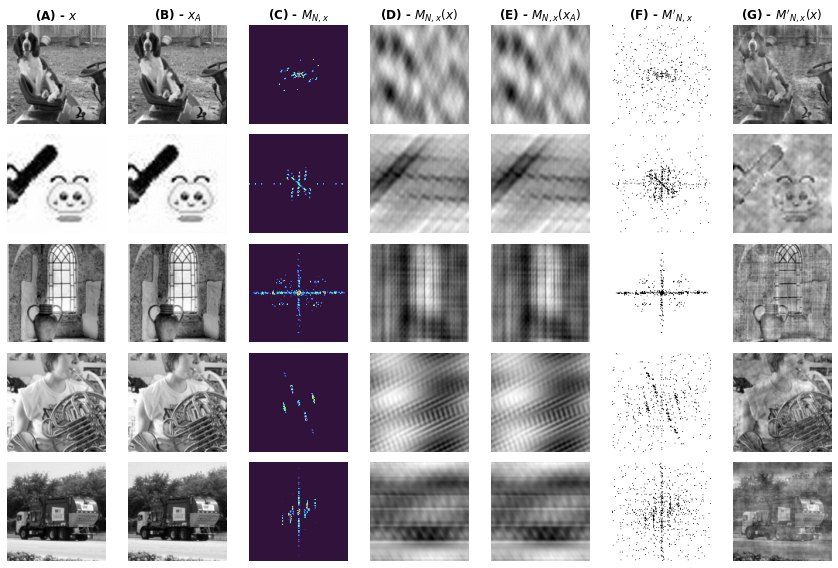

In [6]:
colormap = 'turbo'
c1 = 'Dodgerblue'
c2 = 'tomato'

titles = [
    '(A) - $x$', 
    '(B) - $x_{A}$', 
    '(C) - $M_{N,x}$', 
    '(D) - $M_{N,x}(x)$', 
    "(E) - $M_{N,x}(x_{A})$",
    "(F) - $M'_{N,x}$", 
    "(G) - $M'_{N,x}(x)$"
]

fig, axs = plt.subplots(len(imgidx), len(titles), figsize=(12, 8))

for i, idx in enumerate(imgidx):
    img, adv_img, mask, m_img, cmask, cm_img, m_advimg, label = fig6data[idx]    
    im = axs[i, 0].imshow(denorm(img.squeeze()), cmap='gray')
    im = axs[i, 1].imshow(denorm(adv_img.squeeze()), cmap='gray')
    im = axs[i, 2].imshow(torch.fft.fftshift(mask.squeeze()), cmap=colormap)
    im = axs[i, 3].imshow(m_img.squeeze(), cmap='gray')
    im = axs[i, 4].imshow(m_advimg.squeeze(), cmap='gray')
    im = axs[i, 5].imshow(torch.fft.fftshift(cmask.squeeze()), cmap='gray')
    im = axs[i, 6].imshow(cm_img.squeeze(), cmap='gray')
    
for ax in axs.ravel():
    ax.axis('off')

for i, t in enumerate(titles):
    axs[0, i].set_title(t, weight='bold')

plt.tight_layout()
plt.savefig(f'figs/{architecture}_adv_single_masks.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
labels = {
    '0': 'Eng. springer',
    '1': 'Chain saw',
    '2': 'Church',
    '3': 'French horn',
    '4': 'Garbage truck',
}
label = 0
img_idx = []
for i in range(len(single_img_data.predictions)):
    if label==5:
        break
    pred = single_img_data.predictions[i].item()
    if pred==label:
        img_idx.append(i)
        label += 1

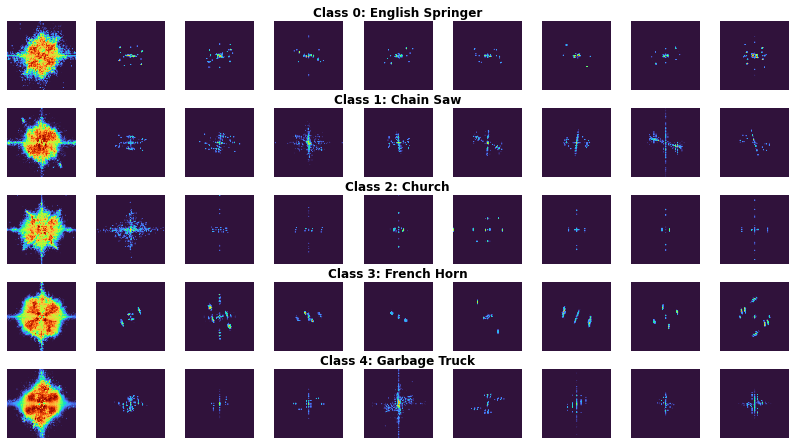

In [7]:
classnames = [
    'English Springer', 
    'Chain Saw', 
    'Church', 
    'French Horn', 
    'Garbage Truck'
]

sample_idx = []
for i in range(5):
    sample_idx.append(
        np.random.choice(
            np.where(single_img_data.predictions==i)[0], 
            size=8, 
            replace=False
        )
    )
sample_idx = np.concatenate(sample_idx)

fig, axs = plt.subplots(5, 9, figsize=(14, 8))
axs1 = axs[:, 1:].ravel()
axs2 = axs[:, 0]

c = 0
for i, (idx, ax) in enumerate(zip(sample_idx, axs1)):
    im = ax.imshow(
        torch.fft.fftshift(single_img_masks.masks[idx].squeeze()), 
        cmap=colormap
    )
    ax.axis('off')
    
from glob import glob

mask_paths = glob('trained_class_specific_masks/*.pt')

for i, ax in enumerate(axs2):
    mask = torch.load(mask_paths[i], map_location='cpu')
    im = ax.imshow(
        torch.fft.fftshift(mask),
        cmap=colormap
    )
    ax.axis('off')

for i in range(5):
    axs[i, 4].text(
        0.5, 1.12,
        f'Class {i}: ' + classnames[i],
        ha='center',
        va='center',
        weight='bold',
        transform = axs[i, 4].transAxes,
        fontsize=12
    )
    
plt.subplots_adjust(wspace=0.3, hspace=0.0)
plt.savefig(
    f'figs/{architecture}_sample_single_masks.jpg', 
    dpi=300, 
    bbox_inches='tight'
)
plt.show()

### Mask & Complementary mask Accuracy 

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Core(num_classes=5, architecture=architecture)
checkpoint = torch.load(f'trained_models/{architecture}_basemodel_n.pt', map_location="cpu")
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()

In [9]:
loader = DataLoader(
    MaskedImages(
        single_img_data,
        single_img_masks,
        mask='standard',
        adv=False
    ), 
    batch_size=1, 
    shuffle=False
)
c_loader = DataLoader(
    MaskedImages(
        single_img_data,
        single_img_masks,
        mask='complement',
        adv=False
    ), 
    batch_size=1, 
    shuffle=False
)
a_loader = DataLoader(
    MaskedImages(
        single_img_data,
        single_img_masks,
        mask=None,
        adv=True
    ),
    batch_size=1,
    shuffle=False
)
r_loader = DataLoader(
    MaskedImages(
        single_img_data,
        single_img_masks,
        mask='standard',
        adv=True
    ),
    batch_size=1,
    shuffle=False
)

In [10]:
accuracy = epoch_test(model, loader, criterion, device).accuracy
c_accuracy = epoch_test(model, c_loader, criterion, device).accuracy
a_accuracy = epoch_test(model, a_loader, criterion, device).accuracy
r_accuracy = epoch_test(model, r_loader, criterion, device).accuracy

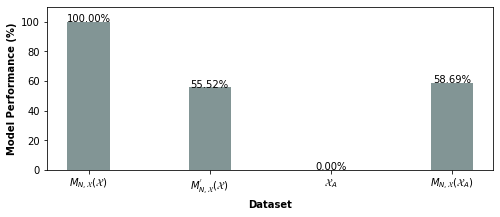

In [11]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], f'{y[i]:.2f}%', ha='center')

fig, ax = plt.subplots(figsize=(8, 3))
 
y = [accuracy, c_accuracy, a_accuracy, r_accuracy]
x = np.arange(len(y))

nets = [
    '$M_{N,\mathcal{X}}(\mathcal{X})$', 
    "$M^{'}_{N,\mathcal{X}}(\mathcal{X})$", 
    "$\mathcal{X}_{A}$",
    "$M_{N, \mathcal{X}}(\mathcal{X}_{A})$"
]

ax.bar(x, y, width=0.35, color='Darkslategray', alpha=0.6)
ax.set_ylim([0, 110])
ax.set_xticks(x)
ax.set_xticklabels(nets, weight='bold')
ax.set_ylabel('Model Performance (%)', weight='bold')
ax.set_xlabel('Dataset', weight='bold')

addlabels(x, y)

plt.savefig(f'figs/{architecture}_mask_performance.png', dpi=300, bbox_inches='tight')
plt.show()

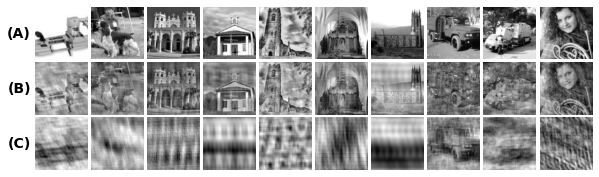

In [20]:
num_images = 10

data = MaskedImages(
    single_img_data, 
    single_img_masks, 
    mask=None, 
    adv=False
)
cdata = MaskedImages(
    single_img_data, 
    single_img_masks, 
    mask='complement', 
    adv=False
)
mdata = MaskedImages(
    single_img_data, 
    single_img_masks, 
    mask='standard', 
    adv=False
)

img_idx = np.random.choice(len(data), size=num_images, replace=False)

labels = ['(A)', '(B)', '(C)']
fig, axs = plt.subplots(3, num_images, figsize=(10, 3))

for i, idx in enumerate(img_idx):
    axs[0, i].imshow(denorm(data[idx][0]).squeeze(), cmap='gray')
    axs[1, i].imshow(denorm(cdata[idx][0]).squeeze(), cmap='gray')
    axs[2, i].imshow(denorm(mdata[idx][0]).squeeze(), cmap='gray')
    
for ax in axs.ravel():
    ax.axis('off')

for j in range(3):
    axs[j, 0].text(
        -0.3, 0.5,
        labels[j],
        ha='center',
        va='center',
        weight='bold',
        transform = axs[j, 0].transAxes,
        fontsize=14
    )
        
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.savefig(
    f'figs/{architecture}_sampled_filtered_img.jpg', 
    dpi=300, 
    bbox_inches='tight'
)
plt.show()

### Single Image Mask Energies

In [17]:
sectors = 64
cm = sns.color_palette(colormap, sectors)

In [18]:
R_diffs = torch.zeros(len(single_img_masks.masks), sectors)
A_diffs = torch.zeros(len(single_img_masks.masks), sectors)

for i in tqdm(range(len(single_img_masks.masks))):
    
    mask = torch.fft.fftshift(single_img_masks.masks[i])
    a_mask = torch.fft.fftshift(single_img_masks.adv_trained_masks[i])
    
    diff = utils.energies(a_mask, sectors)[0] - utils.energies(mask, sectors)[0]
    check = torch.zeros(sectors)
    check[torch.where(diff > 0)[0]] = 1.
    R_diffs[i] = check
    
    diff = utils.energies(a_mask, sectors)[1] - utils.energies(mask, sectors)[1]
    check = torch.zeros(sectors)
    check[torch.where(diff > 0)[0]] = 1.
    A_diffs[i] = check
    
R_portions = R_diffs.mean(0) * 100
A_portions = A_diffs.mean(0) * 100

100%|██████████| 1421/1421 [09:37<00:00,  2.46it/s]


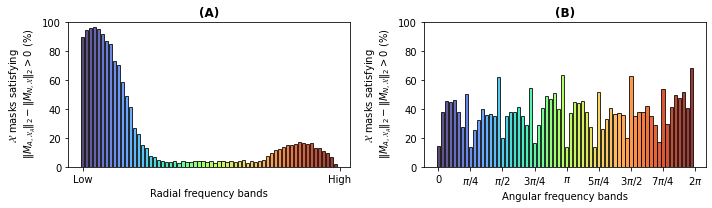

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
opacity = 0.8

axs[0].bar(
    np.arange(len(R_portions)),
    R_portions,
    align='center',
    alpha=opacity,
    edgecolor='black',
    color=cm
)

axs[0].set_xlabel("Radial frequency bands")
axs[0].set_xticks([0, len(R_portions)])
axs[0].set_xticklabels(['Low', 'High'])
axs[0].set_ylabel("$\mathcal{X}$ masks satisfying \n $\Vert M_{A, \mathcal{X}_{A}}\Vert_{2} - \Vert M_{N, \mathcal{X}}\Vert_{2} > 0$ (%)")
axs[0].set_ylim([0, 100])
axs[0].set_title("(A)", weight='bold')

axs[1].bar(
    np.arange(len(A_portions)),
    A_portions,
    align='center',
    alpha=opacity,
    edgecolor='black',
    color=cm
)

axs[1].set_xlabel("Angular frequency bands")
axs[1].set_xticks(np.linspace(0, len(A_portions), 9))
axs[1].set_xticklabels(['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$', '$5\pi/4$', '$3\pi/2$', '$7\pi/4$', '$2\pi$'])
axs[1].set_ylabel("$\mathcal{X}$ masks satisfying \n $\Vert M_{A, \mathcal{X}_{A}}\Vert_{2} - \Vert M_{N, \mathcal{X}}\Vert_{2} > 0$ (%)")
axs[1].set_ylim([0, 100])
axs[1].set_title("(B)", weight='bold')

plt.tight_layout()
plt.savefig(f"figs/{architecture}_single_img_energy_diffs.jpg", bbox_inches="tight", dpi=300)
plt.show()